# 1. Introduction/Business Problem 

If you want to **open a restaurant** in a big city like **Sao Paulo**, it could be a risky business - open it in the wrong neighborhood and you are ruined. In order to achieve success (besides making a great food), it is important to know this business first – so ask yourself:

    1.	What kind of restaurant are you going to open?
    2.	Who is your target?
    3.	Are there other restaurants in the area? How many? Which type?
    4.	Which type of venues exists in the neighborhood? 
    5.	Who lives in the Neighborhood?
    6.	Is the area safe?
    
You will need to address all the questions above if you want to find an answer to the problem, and have a successful restaurant in the city. 

**So the main question is: Where should I open a restaurant in Sao Paulo?**

Data Science can provide tools to dig into this problem, addressing some of the questions above and providing quantitative answers and insights that will help you to take right decision, and chose the best neighborhood to open a restaurant in Sao Paulo.

Most of the data needed to solve this problem can be retrieved using FourSquare:

    •	Venues list for each neighborhood;
    •	Venues categories list for each neighborhood;
    •	Venues prices classification for each venue (rated by customer);

This data will be processed, analyzed, and the end, it will produce insights that will tell more about each neighborhood in the city. Neighborhoods should be grouped by a machine leaning method (K-Means).

**The aim of this research** is to identify the **top 5 neigborhoods to open a restaurant in the City of Sao Paulo**. 


To start with,lets import the required libraries to run this notebook:

## Import libraries to run the notebook:

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


# 2. Data Section

To address the question "Where to open a restaurant on Sao Paulo, we will need to get two sets of data, to be stored in the following Pandas Dataframes:

**spdf**: These database contains the latitude and longitude of each neighborhood of Sao Paulo. It has the following columns:

    • Neighborhood: the name of the Neighborhood
    • Latitude....: the latitude of the Neighborhood
    • Longitude...: the longitude of the Neighborhood
    • Size........: This column will be used to define the relative "Size" of the Neighborhood. Size coud be, for exemplo, the number of expenvive restaurants in the area.

**sp_venues**: These database contains the Venues list for each neighborhood of Sao Paulo, with the following columns:

    • Neighborhood..........: the name of the Neighborhood
    • Neighborhood Latitude.: the latitude of the Neighborhood
    • Neighborhood Longitude: the longitude of the Neighborhood
    • Venue.................: Venue name
    • Venue Latitude........: Venue latitude
    • Venue Longitude.......: Venue longitude
    • Venue Category........: Venue Category 
    • Price.................: Client evaluation number from 1 (cheap) to 4 (expensive) rating the prices of the Venue.




## 2.1 Getting the Sao Paulo Neighborhoods:

The first step to get the data is getting the Latitude and Longitude of Sao Paulo neighborhoods. Since I could not find any  avaliable for download, neither I have de address of each central point of each neighborhood, had to build my own database. What I did:

    • Create an excel file named 'sp-neighborhoods.xls', with the following columns:
        • Neighborhood: the name of the Neighborhood
        • Latitude: the latitude of the Neighborhood
        • Longitude: the longitude of the Neighborhood
        • Size: This column will be used to define the relative "Size" of the Neighborhood. Size coud be, for exemplo, the number of expenvive restaurants in the area.
   
    • Using google maps, I got the latitude and longitude of the central point (visually estimated) of each neighborhood, and registered it in the excel file 'sp-neighborhoods.xls'
   
    • Column 'Size" was set at this stage to 10 (it will be modified later)

At the end, I build a database with 91 neighborhoods for the city of Sao Paulo. 

Let's read it and put into a Pandas Dataframe **spdf**:

### spdf dataframe

In [390]:
#Read into a pandas DataFrame, the Neighborhoods Latitude and Longitude for the city of Sao Paulo:
spdf=pd.read_excel('sp-neighborhoods.xls', index_col=0) 
spdf.head(10)

,Neighborhood,Latitude,Longitude,Size
index,,,,
0,Pinheiros (Paes Leme),-23.566997,-46.696343,10
1,Pinheiros (Fradique),-23.563412,-46.684643,10
2,Vila Madalena,-23.553547,-46.688649,10
3,Alto de Pinheiros,-23.553213,-46.708974,10
4,Boacava,-23.541327,-46.720548,10
5,Clinicas,-23.556694,-46.675425,10
6,Pacaembu,-23.546327,-46.668858,10
7,Jardim Europa,-23.574492,-46.681769,10
8,Itaim,-23.584443,-46.679146,10


As explained before, **size** is set a constant value for now. We will deal with this column later.

### Display São Paulo Neighborhoods:
the following function will display the Neighborhoods of Sao Paulo. The size (radius) of each Neighborhood displayed in the map:

In [391]:
def display_neighborhoods(df):    
    map_SP = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)
    # add markers to map
    for lat, lng, neighborhood, size in zip(df['Latitude'], df['Longitude'], df['Neighborhood'],df['Size']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=size/2,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_SP)
    return map_SP
    

In [392]:
display_neighborhoods(spdf)

... and just in case the Folium image above does not show in GitHub, I captured it in a JPG format below:

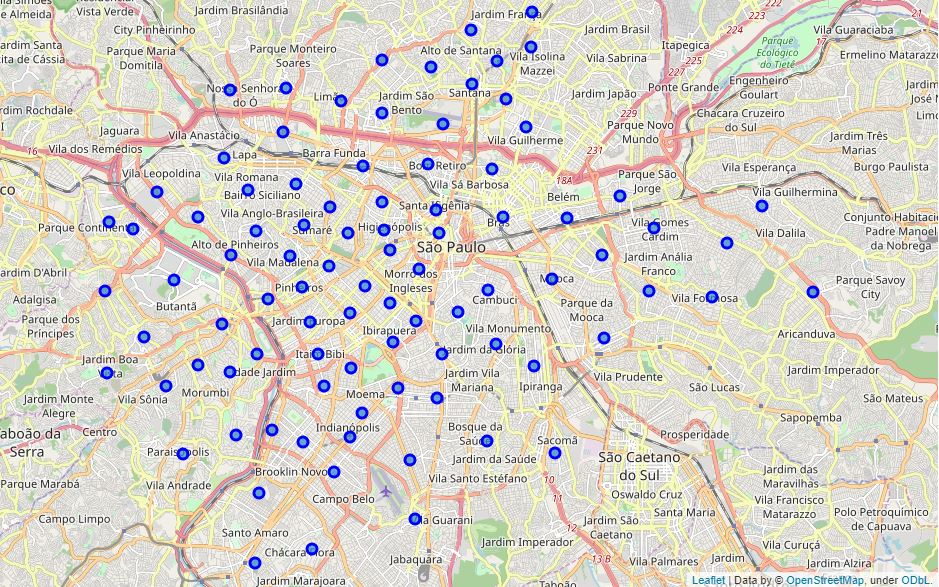

In [418]:
from IPython.display import Image
Image(filename='sp-neighborhoods.JPG') 

### Let's find the average distance between neighborhoods:
The funcion below calculate the distance between 2 points using Latitudes and Longitudes:

In [393]:
from math import cos, asin, sqrt, pi
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) 

The loop below build a Distance Matrix. For each point (Neighborhood) is calculated the distance for every other point (Neighborhood) in spdf dataframe:

In [185]:
distance_between_neighborhoods = np.zeros([spdf.shape[0],spdf.shape[0]])
for i in range(0,spdf.shape[0]):
    for j in range(0,spdf.shape[0]):
        if i == j:
            distance_between_neighborhoods[i,j] = 9999999.  #Distance from 'itself' should not be considered 
        else:
            distance_between_neighborhoods[i,j] = distance (spdf.iloc[i,1],spdf.iloc[i,2],spdf.iloc[j,1],spdf.iloc[j,2]) 

The loop below get the minimum distance that each Neighborhood is from is closest neighbor:

In [186]:
smallest_distance_between_neighborhoods = []
for i in range(0,spdf.shape[0]):
    smallest_distance_between_neighborhoods.append(distance_between_neighborhoods[i,:].min())
df_smallest_distance_between_neighborhoods = pd.DataFrame(smallest_distance_between_neighborhoods)
df_smallest_distance_between_neighborhoods.columns=['Smallest distance between each Neighborhoods']
df_smallest_distance_between_neighborhoods.describe()

,Smallest distance between each Neighborhoods
count,91.000000
mean,1.459429
std,0.447308
min,0.741260
25%,1.137664
50%,1.387757
75%,1.720193
max,3.452532


#### From the above, we conclude that:
    * The Average distance between Neighborhoods is aproximately 1.46km
    * The 1st and 3rd Quartile are: 1.13km and 1.72 km 
    * The radius to pass to Foursquare URL request should be 1.46km / 2 = aprox. 750m

## 2.2 Getting the Venues Neighborhoods from Foursquare:
To build our database **sp_venues** described in item 2. of this report, I need to make a foursquare request, using the GET method and the EXPLORE endpoint to retrieve the data.

I will specify in the Foursquare request:

    • CLIENT_ID ...: Personal info for 'login'
    • CLIENT_SECRET: Personal info for 'login'
    • VERSION .....: Foursquare API version
    • price_filter : Price filter from 1 to 4
    • LIMIT .......: Maximum number of venues to return in the request
    • RADIUS ......: All venues found within this radius will be returned in the request 

In [394]:
CLIENT_ID = 'JQG5FSEDWNAKRBKQRF3ZVD4Y2TCPWJN0Y0ZCBRD5LXPQOR1K' # your Foursquare ID

CLIENT_SECRET = 'P5IDUFL0YMGDLETV5Y3XPEY504VUHNRXIVFBIHYCPMEGOARS' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

LIMIT = 120 # limit of number of venues returned by Foursquare API

RADIUS = 750 # define radius

### Function to get venues from Forsquare:

In [397]:
def getNearbyVenues(names, latitudes, longitudes, price_filter):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, ' ( R=',RADIUS,', Price=',price_filter,')')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(               
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            price_filter)
            
        # make the GET request        
        results = requests.get(url).json()
        
        if str(results).find('groups') > 0:
            results=results["response"]['groups'][0]['items']        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues from Foursquare:

Data will be retrieved in four parts, each part having the venues for a specific price filter:

    • sp_venues_p1: all venues having price = 1 (cheaper)
    • sp_venues_p2: all venues having price = 2 
    • sp_venues_p3: all venues having price = 3 
    • sp_venues_p4: all venues having price = 4 (expensive)
    
Then, all these 4 dataframes will be merged into a bigger one:

    • sp_venues: list of all venues in the city of Sao Paulo, having prices from 1 to 4

In [400]:
sp_venues_p1 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=1)

Pinheiros (Paes Leme)  ( R= 750 , Price= 1 )
Pinheiros (Fradique)  ( R= 750 , Price= 1 )
Vila Madalena  ( R= 750 , Price= 1 )
Alto de Pinheiros  ( R= 750 , Price= 1 )
Boacava  ( R= 750 , Price= 1 )
Clinicas  ( R= 750 , Price= 1 )
Pacaembu  ( R= 750 , Price= 1 )
Jardim Europa  ( R= 750 , Price= 1 )
Itaim  ( R= 750 , Price= 1 )
Vila Olimpia  ( R= 750 , Price= 1 )
Brooklyn  ( R= 750 , Price= 1 )
Vila Funchal  ( R= 750 , Price= 1 )
Moema  ( R= 750 , Price= 1 )
Indianopolis  ( R= 750 , Price= 1 )
Campo Belo  ( R= 750 , Price= 1 )
Vila Nova Conceicao  ( R= 750 , Price= 1 )
Pq Ibirapuera  ( R= 750 , Price= 1 )
Cerqueira Cesar  ( R= 750 , Price= 1 )
Jardins  ( R= 750 , Price= 1 )
Pamplona  ( R= 750 , Price= 1 )
Consolacao  ( R= 750 , Price= 1 )
Higienopolis  ( R= 750 , Price= 1 )
Perdizes  ( R= 750 , Price= 1 )
Sumare  ( R= 750 , Price= 1 )
Vila Beatriz  ( R= 750 , Price= 1 )
Lapa  ( R= 750 , Price= 1 )
Agua Branca  ( R= 750 , Price= 1 )
Barra Funda  ( R= 750 , Price= 1 )
Bixiga  ( R= 750 , Pr

Ok, it worked! So let's get the next tree venues list for price tags 2, 3 and 4:

In [422]:
sp_venues_p2 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=2)
sp_venues_p3 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=3)
sp_venues_p4 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=4)

... and add the price tag to each respective dataframe:

In [408]:
sp_venues_p1['Price']=1
sp_venues_p2['Price']=2
sp_venues_p3['Price']=3
sp_venues_p4['Price']=4

### Create dataframe sp_venues:

And now let's concatenate all 4 databases (each one for a specific price tag) into sp_venues:

In [409]:
sp_venues = pd.concat([sp_venues_p1,sp_venues_p2,sp_venues_p3,sp_venues_p4])

In [415]:
print('Total venues in sp_venues ..................: ',sp_venues.shape[0])
print('Total venues in sp_venues_pi (i from 1 to 4): ',sp_venues_p1.shape[0]+sp_venues_p2.shape[0]+sp_venues_p3.shape[0]+sp_venues_p4.shape[0])

Total venues in sp_venues ..................:  4647
Total venues in sp_venues_pi (i from 1 to 4):  4647


And **sp_venues** dataframe looks like this:

In [421]:
sp_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Price
0,Pinheiros (Paes Leme),-23.566997,-46.696343,Pitico,-23.566305,-46.696066,Beer Garden,1
1,Pinheiros (Paes Leme),-23.566997,-46.696343,Comedoria,-23.567765,-46.697848,Buffet,1
2,Pinheiros (Paes Leme),-23.566997,-46.696343,Bráz Elettrica,-23.566013,-46.695895,Pizza Place,1
3,Pinheiros (Paes Leme),-23.566997,-46.696343,St. Chico Padaria,-23.565137,-46.695565,Bakery,1
4,Pinheiros (Paes Leme),-23.566997,-46.696343,Um Coffee Co.,-23.568214,-46.698818,Coffee Shop,1
5,Pinheiros (Paes Leme),-23.566997,-46.696343,Remelexo Brasil,-23.567562,-46.698365,Nightclub,1
6,Pinheiros (Paes Leme),-23.566997,-46.696343,Neko's Burger,-23.567836,-46.699692,Burger Joint,1
7,Pinheiros (Paes Leme),-23.566997,-46.696343,Lupe Bar Y Taqueria,-23.563541,-46.693151,Taco Place,1
8,Pinheiros (Paes Leme),-23.566997,-46.696343,Joe King Coffee Shop,-23.563789,-46.695761,Coffee Shop,1
9,Pinheiros (Paes Leme),-23.566997,-46.696343,Buzina,-23.563703,-46.692851,Burger Joint,1


I am going to store each of these dafatrames into an excel file, so I can load these data easily next time:

In [411]:
sp_venues_p1.to_excel('sp_venues_p1.xls')
sp_venues_p2.to_excel('sp_venues_p2.xls')
sp_venues_p3.to_excel('sp_venues_p3.xls')
sp_venues_p4.to_excel('sp_venues_p4.xls')
sp_venues.to_excel('sp_venues.xls')

... and if i need to load them again, I just uncomment the follwing:

In [412]:
#Read data from 4 excel file:
#sp_venues_p1 = pd.read_excel('sp_venues_p1.xls')
#sp_venues_p2 = pd.read_excel('sp_venues_p2.xls')
#sp_venues_p3 = pd.read_excel('sp_venues_p3.xls')
#sp_venues_p4 = pd.read_excel('sp_venues_p4.xls')
#sp_venues = pd.read_excel('sp_venues.xls')
#sp_venues_p1.drop(['Unnamed: 0'],axis=1,inplace=True)
#sp_venues_p2.drop(['Unnamed: 0'],axis=1,inplace=True)
#sp_venues_p3.drop(['Unnamed: 0'],axis=1,inplace=True)
#sp_venues_p4.drop(['Unnamed: 0'],axis=1,inplace=True)
#sp_venues.drop(['Unnamed: 0'],axis=1,inplace=True)

With that in hand, the next step (week 2) is dig into this data, analyse it and get some useful insights that will be able to answers the main question:

**Identify the top 5 neigborhoods to open a restaurant in the City of Sao Paulo**

### How many venues for each neighborhood:

In [193]:
#Get Neighborhoods with number of Venues < 15:
n_venues = sp_venues[['Venue','Neighborhood']].groupby('Neighborhood').count().sort_values('Venue',ascending=False)

In [194]:
n_venues

,Venue
Neighborhood,
Itaim,169
Cerqueira Cesar,145
Pinheiros (Paes Leme),141
Pinheiros (Fradique),141
Consolacao,133
Pamplona,132
Ahangabau,132
Paraiso,115
Moema,113


In [195]:
neighborhoods_with_venues_under_15 = n_venues[n_venues['Venue']<15].index
neighborhoods_with_venues_under_15

Index(['Butanta-USP', 'Rio Pequeno', 'Parque Anhembi',
       'Favela Sao Remo (Jaguare)', 'Vila Guilherme', 'Morumbi', 'Boacava',
       'Piqueri', 'Jaguare', 'Alto de Pinheiros', 'Jokey Clube',
       'Favela Paraisopolis', 'Chacara Flora'],
      dtype='object', name='Neighborhood')

In [196]:
#repair:
#sp_venues_f.reset_index(inplace = True)
#sp_venues_f.drop(['index'],axis=1,inplace = True)

In [225]:
#DROP neighborhoods with less than 15 venues:
#--------------------------------------------
sp_venues_f = sp_venues.set_index('Neighborhood').drop(neighborhoods_with_venues_under_15, axis=0) #inplace=True
spdf_f = spdf.set_index('Neighborhood').drop(neighborhoods_with_venues_under_15, axis=0) #inplace=True

In [226]:
sp_venues_f.reset_index(inplace = True)
spdf_f.reset_index(inplace = True)

In [227]:
#sp_venues_f.reset_index(inplace = True)
sp_venues_f.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Price
0,Pinheiros (Paes Leme),-23.566997,-46.696343,Pitico,-23.566305,-46.696066,Beer Garden,1
1,Pinheiros (Paes Leme),-23.566997,-46.696343,Comedoria,-23.567765,-46.697848,Buffet,1
2,Pinheiros (Paes Leme),-23.566997,-46.696343,Bráz Elettrica,-23.566013,-46.695895,Pizza Place,1
3,Pinheiros (Paes Leme),-23.566997,-46.696343,St. Chico Padaria,-23.565137,-46.695565,Bakery,1
4,Pinheiros (Paes Leme),-23.566997,-46.696343,Um Coffee Co.,-23.568214,-46.698818,Coffee Shop,1


In [228]:
#spdf_f.reset_index(inplace = True)
spdf_f.head()

,Neighborhood,Latitude,Longitude,Size
0,Pinheiros (Paes Leme),-23.566997,-46.696343,10
1,Pinheiros (Fradique),-23.563412,-46.684643,10
2,Vila Madalena,-23.553547,-46.688649,10
3,Clinicas,-23.556694,-46.675425,10
4,Pacaembu,-23.546327,-46.668858,10


In [347]:
#temp4=sp_venues_f[sp_venues_f['Price']==4][['Neighborhood','Price']]    
#.columns=['Neighborhood','Latitude','Longitude']

sp_prices_4 = sp_venues_p4[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)
sp_prices_3 = sp_venues_p3[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)//3
sp_prices_2 = sp_venues_p2[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)//2
sp_prices_1 = sp_venues_p1[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)

sp_prices_1 = sp_prices_1.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
sp_prices_2 = sp_prices_2.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
sp_prices_3 = sp_prices_3.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
sp_prices_4 = sp_prices_4.reset_index().merge(spdf, on = "Neighborhood", how = "inner")

sp_prices_1['Size'] = sp_prices_1['Price']
sp_prices_2['Size'] = sp_prices_2['Price']
sp_prices_3['Size'] = sp_prices_3['Price']
sp_prices_4['Size'] = sp_prices_4['Price']

display_neighborhoods(sp_prices_3)

In [230]:
sp_venues_f.shape

(4487, 8)

In [231]:
len(sp_venues_f['Venue'].unique())

3582

### Unique categories in column "Venue Category":

In [232]:
len(sp_venues_f['Venue Category'].unique())

152

In [212]:
#NAO FAZER MAIS

In [58]:
#Send Venues Categories to excel:
#pd.DataFrame(sp_venues_f['Venue Category'].unique()).to_excel('sp_venues.xls')


In [211]:
#Edit above file in excel, group Venues into specific categories, and load back here into sp_venues_grouped:
#sp_venues_grouped = pd.read_excel('sp_venues_grouped.xls')
#sp_venues_grouped.set_index('venues', inplace=True)
#sp_venues_grouped.head() 

In [ ]:
#for i in range(0,sp_venues_f.shape[0]):
#    sp_venues_f.iloc[i,7]=sp_venues_grouped.loc[sp_venues_f.iloc[i,6],'group'] #update group in sp_venues_f

In [225]:
#Create column 'Venue Group' and update it with group in sp_venues_grouped:
for i in range(0,sp_venues_f.shape[0]):    
    #sp_venues_f.iloc[i,7]=sp_venues_grouped.loc[sp_venues_f.iloc[i,6],'group'] #update group in sp_venues_f
    if sp_venues_f.iloc[i,6].find('Restaurant') > 0:
        sp_venues_f.iloc[i,7] ='Restaurant'
    else:
        sp_venues_f.iloc[i,7] ='Other'
            
sp_venues_f.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,Pinheiros (Paes Leme),-23.566997,-46.696343,Teatro Paulo Autran,-23.567738,-46.697802,Theater,Other
1,Pinheiros (Paes Leme),-23.566997,-46.696343,Mica,-23.566173,-46.695865,Asian Restaurant,Restaurant
2,Pinheiros (Paes Leme),-23.566997,-46.696343,Pitico,-23.566305,-46.696066,Beer Garden,Other
3,Pinheiros (Paes Leme),-23.566997,-46.696343,Fitó,-23.568101,-46.694906,Northeastern Brazilian Restaurant,Restaurant
4,Pinheiros (Paes Leme),-23.566997,-46.696343,HM Food Café,-23.567217,-46.698306,Coffee Shop,Other


In [224]:
#total Restaurants per Neighborhoods:
#sp_venues_f[sp_venues_f['Venue Group']=='Restaurant'].groupby('Neighborhood').count()['Venue Group'].sort_values(ascending=False)

In [233]:

sp_venues_f.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Price
0,Pinheiros (Paes Leme),-23.566997,-46.696343,Pitico,-23.566305,-46.696066,Beer Garden,1
1,Pinheiros (Paes Leme),-23.566997,-46.696343,Comedoria,-23.567765,-46.697848,Buffet,1
2,Pinheiros (Paes Leme),-23.566997,-46.696343,Bráz Elettrica,-23.566013,-46.695895,Pizza Place,1
3,Pinheiros (Paes Leme),-23.566997,-46.696343,St. Chico Padaria,-23.565137,-46.695565,Bakery,1
4,Pinheiros (Paes Leme),-23.566997,-46.696343,Um Coffee Co.,-23.568214,-46.698818,Coffee Shop,1


### One Hot Encoding:

In [274]:
#group_column = 'Venue Category'

#sp_venues_f['Price']= sp_venues_f['Price'].astype(int)
sp_venues_f['Price']= sp_venues_f['Price']/4

group_column = ['Venue Category']
sp_onehot = pd.get_dummies(sp_venues_f[group_column], prefix="", prefix_sep="")
sp_onehot['Price'] = sp_venues_f['Price']
sp_onehot['Neighborhood'] = sp_venues_f['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [sp_onehot.columns[-1]] + [sp_onehot.columns[-2]] + list(sp_onehot.columns[:-2])
sp_onehot = sp_onehot[fixed_columns]
sp_onehot.head()

,Neighborhood,Price,Acai House,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Baiano Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Borek Place,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donburi Restaurant,Doner Restaurant,Donut Shop,Empada House,Empanada Restaurant,English Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Flower Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Halal Restaurant,History Museum,Hookah Bar,Hot Dog Joint,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Organic Grocery,Paella Restaurant,Pastelaria,Pastry Shop,Peruvian Restaurant,Pet Store,Piadineria,Pie Shop,Pizza Place,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Street Art,Street Food Gathering,Strip Club,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Pinheiros (Paes Leme),0.0625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pinheiros (Paes Leme),0.0625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pinheiros (Paes Leme),0.0625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Pinheiros (Paes Leme),0.0625,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Pinheiros (Paes Leme),0.0625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [275]:
#sp_onehot['Price']= sp_onehot['Price'].astype(int)

In [276]:
sp_onehot.shape

(4487, 154)

In [290]:
sp_grouped = sp_onehot.groupby('Neighborhood').mean().reset_index()
sp_grouped_wp = sp_grouped.drop("Price", axis = 1)
#sp_grouped
#sp_grouped.sort_values('Restaurant',ascending=False)

### Number of Neighborhoods in sp_grouped:

In [291]:
sp_grouped.shape

(78, 154)

In [292]:
sp_grouped.head()

,Neighborhood,Price,Acai House,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Baiano Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Borek Place,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donburi Restaurant,Doner Restaurant,Donut Shop,Empada House,Empanada Restaurant,English Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Flower Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Halal Restaurant,History Museum,Hookah Bar,Hot Dog Joint,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Organic Grocery,Paella Restaurant,Pastelaria,Pastry Shop,Peruvian Restaurant,Pet Store,Piadineria,Pie Shop,Pizza Place,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Street Art,Street Food Gathering,Strip Club,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Aclimacao,0.112805,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.097561,0.0,0.0,0.097561,0.097561,0.0,0.0,0.0,0.000000,0.0,0.0,0.024390,0.000000,0.0000,0.0,0.024390,0.000000,0.000000,0.04878,0.0,0.000000,0.0,0.000000,0.024390,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.073171,0.02439,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.024390,0.024390,0.000000,0.0,0.024390,0.0,0.0,0.073171,0.0,0.000000,0.0,0.0,0.024390,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.121951,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.024390,0.0,0.0,0.024390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048780,0.0,0.0,0.0,0.073171,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.024390,0.0,0.0,0.000000,0.0,0.0
1,Agua Branca,0.125000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,0.0,0.000000,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.300000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.050000,0.0,0.000000,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.05,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.050000,0.0,0.000000,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,

In [368]:
vv='Italian Restaurant'
sp_grouped[['Neighborhood',vv]].sort_values(vv, ascending=False)

,Neighborhood,Italian Restaurant
35,Jardins,0.185185
17,Cerqueira Cesar,0.124138
32,Jardim Europa,0.120000
28,Itaim,0.112426
38,Mandaqui,0.105263
18,Chacara Santo Antonio,0.101852
15,Carandiru,0.100000
71,Vila Nova Conceicao,0.098592
75,Vila Reg. Feijo,0.093750
72,Vila Olimpia,0.090909


### Top 5 Venues for each Neighborhood:

In [293]:
num_top_venues = 5

for hood in sp_grouped_wp['Neighborhood']:
    print("----"+hood+"----")
    temp = sp_grouped_wp[sp_grouped_wp['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aclimacao----
              venue   freq
0       Pizza Place  0.122
1         BBQ Joint  0.098
2               Bar  0.098
3            Bakery  0.098
4  Sushi Restaurant  0.073


----Agua Branca----
                    venue  freq
0    Brazilian Restaurant  0.30
1              Restaurant  0.20
2    Fast Food Restaurant  0.10
3                     Bar  0.10
4  Furniture / Home Store  0.05


----Agua Rasa----
                  venue   freq
0          Burger Joint  0.156
1  Brazilian Restaurant  0.156
2                   Bar  0.094
3           Pizza Place  0.062
4                Bakery  0.062


----Ahangabau----
                  venue   freq
0  Brazilian Restaurant  0.174
1                  Café  0.098
2           Coffee Shop  0.083
3                Bakery  0.068
4                   Bar  0.061


----Barra Funda----
                  venue   freq
0             Nightclub  0.190
1            Restaurant  0.121
2  Brazilian Restaurant  0.121
3  Fast Food Restaurant  0.086
4                

                  venue   freq
0  Brazilian Restaurant  0.235
1            Food Truck  0.088
2          Dessert Shop  0.059
3             BBQ Joint  0.059
4           Pizza Place  0.059


----Vila Madalena----
            venue   freq
0             Bar  0.192
1      Restaurant  0.077
2     Pizza Place  0.077
3  Ice Cream Shop  0.048
4            Café  0.038


----Vila Mariana----
            venue   freq
0             Bar  0.087
1     Pizza Place  0.076
2  Ice Cream Shop  0.065
3    Dessert Shop  0.065
4      Restaurant  0.065


----Vila Matilde----
            venue   freq
0     Pizza Place  0.188
1             Bar  0.125
2  Ice Cream Shop  0.094
3          Bakery  0.094
4    Burger Joint  0.062


----Vila Nova Conceicao----
                venue   freq
0          Restaurant  0.141
1  Italian Restaurant  0.099
2        Burger Joint  0.070
3         Pizza Place  0.070
4           Gastropub  0.042


----Vila Olimpia----
                       venue   freq
0         Italian Restaurant  0

### Most Comon Venues:

In [350]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

In [351]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sp_grouped_wp['Neighborhood'] 

for ind in np.arange(sp_grouped_wp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sp_grouped_wp.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aclimacao,Pizza Place,Bar,BBQ Joint,Bakery,Sushi Restaurant,Korean Restaurant,Dessert Shop,Chinese Restaurant,Steakhouse,Burger Joint
1,Agua Branca,Brazilian Restaurant,Restaurant,Bar,Fast Food Restaurant,Pizza Place,Food Truck,Coffee Shop,BBQ Joint,Furniture / Home Store,Churrascaria
2,Agua Rasa,Brazilian Restaurant,Burger Joint,Bar,Bakery,Brewery,Pizza Place,Pastelaria,Ice Cream Shop,Fast Food Restaurant,Restaurant
3,Ahangabau,Brazilian Restaurant,Café,Coffee Shop,Bakery,Bar,Restaurant,Italian Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop
4,Barra Funda,Nightclub,Restaurant,Brazilian Restaurant,Fast Food Restaurant,Café,Sandwich Place,Italian Restaurant,Japanese Restaurant,Bar,Bakery


In [352]:
neighborhoods_venues_sorted.shape[0]

78

### Cluster Neighborhoods with K-Means:
number of clusters = 5

In [353]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5
sp_grouped_clustering = sp_grouped_wp.drop('Neighborhood', 1)
# k-means clustering:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sp_grouped_clustering)

In [354]:
# check cluster labels and count:
pd.DataFrame(kmeans.labels_)[0].value_counts()

3    31
1    20
0    13
4     7
2     7
Name: 0, dtype: int64

In [355]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sp_merged = spdf_f

# merge data to add latitude/longitude for each neighborhood
sp_merged = sp_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [356]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4])

In [357]:
sp_merged.head()

,Neighborhood,Latitude,Longitude,Size,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pinheiros (Paes Leme),-23.566997,-46.696343,10,3,Brazilian Restaurant,Burger Joint,Coffee Shop,Restaurant,Bar,Japanese Restaurant,Café,Nightclub,Italian Restaurant,Vegetarian / Vegan Restaurant
1,Pinheiros (Fradique),-23.563412,-46.684643,10,3,Italian Restaurant,Brazilian Restaurant,Restaurant,Pizza Place,Bar,Burger Joint,Coffee Shop,Dessert Shop,Japanese Restaurant,Vegetarian / Vegan Restaurant
2,Vila Madalena,-23.553547,-46.688649,10,1,Bar,Restaurant,Pizza Place,Ice Cream Shop,Café,Burger Joint,Bakery,Brazilian Restaurant,Dive Bar,Vegetarian / Vegan Restaurant
3,Clinicas,-23.556694,-46.675425,10,3,Restaurant,Bar,Pizza Place,Coffee Shop,Brazilian Restaurant,Café,Burger Joint,Italian Restaurant,Dessert Shop,Nightclub
4,Pacaembu,-23.546327,-46.668858,10,1,Dessert Shop,Bakery,Burger Joint,Food Truck,Japanese Restaurant,Pizza Place,Coffee Shop,Soccer Stadium,Lounge,Deli / Bodega


### Vizualize Neighborhoods Clusters in folium Map:

In [358]:
# create Folium map for Toronto Neighborhoods:
map_clusters = folium.Map(location=[spdf_f.loc[2,'Latitude'], spdf_f.loc[2,'Longitude'] ], zoom_start=12)

# set color scheme for the clusters:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
#           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen','gray', 'black', 'lightgray']

# add markers to the map:
markers_colors = []
for lat, lon, poi, cluster in zip(sp_merged['Latitude'], sp_merged['Longitude'], sp_merged['Neighborhood'], sp_merged['Cluster Labels']):    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='black',  #rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [120]:
#Count the frequencie of Venue in the whole Cluster
def cluster_freq(cluster):    
    c_list=[]
    for i in range(0,cluster.shape[0]):
        for j in range(1,cluster.shape[1]):            
            c_list.append(cluster.iloc[i,j])
    count=pd.DataFrame(c_list)[0].value_counts()
    return count
    

#### 1st Cluster (label_ = 0):

In [121]:
C0=sp_merged.loc[ sp_merged['Cluster Labels'] == 0,  sp_merged.columns[  [0] + list(range(4, sp_merged.shape[1]))]  ]
C0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Boacava,Store,Food Venues,Pharmacy,Restaurant,Plaza,Beauty,Market,Fitness,Pizza Restaurant,Farm
6,Pacaembu,Food Venues,Store,Health service,Plaza,Shop & Service,Culture Venues,Spa,Stadium,Restaurant,Lounge
7,Jardim Europa,Store,Culture Venues,Plaza,Food Venues,Restaurant,Beauty,Spa,Construction & Landscaping,Market,Entertainment
13,Indianopolis,Food Venues,Store,Restaurant,Beauty,Fitness,Bar,Entertainment,Spa,accomodation,Smoke Shop
18,Jardins,Store,Food Venues,Restaurant,Plaza,Fitness,Culture Venues,Pharmacy,Track,Office,Optical Shop
29,Bras,Store,Food Venues,Restaurant,Fitness,Health Food Venues,Platform,Plaza,Entertainment,Convenience Store,accomodation
36,Jokey Clube,Store,Restaurant,Plaza,Theme Park,Fitness,Food Venues,Park,Racetrack,Bank,Indoor Play Area
37,Vila Sonia,Food Venues,Pizza Restaurant,Store,Restaurant,Fitness,Skate Park,Convenience Store,Health Food Venues,Entertainment,Market
41,Favela Princesinha (Shop.Raposo),Store,Restaurant,Food Venues,Entertainment,Pizza Restaurant,Culture Venues,Stadium,Pet,Beauty,Fitness
49,Santa Ifigenia,Store,Restaurant,Food Venues,accomodation,Culture Venues,Bar,Mall,Plaza,Fitness,Souvenir Shop


In [122]:
cluster_freq(C0)

Food Venues                   10
Store                         10
Restaurant                    10
Fitness                        8
Plaza                          7
Culture Venues                 5
Entertainment                  5
Beauty                         4
Market                         3
Pizza Restaurant               3
Spa                            3
accomodation                   3
Stadium                        2
Pharmacy                       2
Convenience Store              2
Health Food Venues             2
Bar                            2
Office                         1
Souvenir Shop                  1
Skate Park                     1
Indoor Play Area               1
Track                          1
Mall                           1
Farm                           1
Health service                 1
Optical Shop                   1
Park                           1
Racetrack                      1
Shop & Service                 1
Pet                            1
Constructi

#### 2nd Cluster (label_ = 1)

In [123]:
C1=sp_merged.loc[ sp_merged['Cluster Labels'] == 1,  sp_merged.columns[  [0] + list(range(4, sp_merged.shape[1]))]  ]
C1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pinheiros (Paes Leme),Food Venues,Restaurant,Store,Bar,Entertainment,Pizza Restaurant,accomodation,Fitness,Drink,Gastropub
1,Pinheiros (Fradique),Restaurant,Food Venues,Store,Bar,Pizza Restaurant,Entertainment,Culture Venues,Drink,Fitness,Plaza
5,Clinicas,Restaurant,Food Venues,Culture Venues,Bar,Entertainment,Fitness,accomodation,Drink,Flower Shop,Gastropub
8,Itaim,Restaurant,Food Venues,Bar,Fitness,Store,accomodation,Entertainment,Lounge,Pizza Restaurant,Multiplex
9,Vila Olimpia,Restaurant,Food Venues,Bar,Fitness,Store,Pizza Restaurant,Spa,accomodation,Beauty,Cycle Studio
10,Brooklyn,Restaurant,Food Venues,Fitness,Bar,Pizza Restaurant,Store,Spa,Pharmacy,Park,Bistro
12,Moema,Restaurant,Food Venues,accomodation,Store,Beauty,Market,Bar,Pizza Restaurant,Plaza,Spa
15,Vila Nova Conceicao,Restaurant,Food Venues,Pizza Restaurant,Bar,Culture Venues,Store,accomodation,Spa,Yoga Studio,Park
16,Pq Ibirapuera,Restaurant,Food Venues,Fitness,Store,Bar,Plaza,accomodation,Street Food Gathering,Culture Venues,Convenience Store
17,Cerqueira Cesar,Restaurant,Food Venues,Store,accomodation,Entertainment,Bar,Fitness,Pizza Restaurant,Culture Venues,Poke Place


In [124]:
cluster_freq(C1)

Bar                      14
Food Venues              14
Restaurant               14
Store                    13
Fitness                  12
accomodation             12
Pizza Restaurant         10
Culture Venues            8
Entertainment             7
Plaza                     4
Spa                       4
Beauty                    3
Drink                     3
Market                    3
Gastropub                 2
Convenience Store         2
Flower Shop               2
Park                      2
Pharmacy                  1
Miscellaneous Shop        1
Multiplex                 1
Lounge                    1
Soup Place                1
Stadium                   1
Poke Place                1
Bistro                    1
Cycle Studio              1
Yoga Studio               1
Street Food Gathering     1
Name: 0, dtype: int64

#### 3rd Cluster (label_ = 2)

In [125]:
C2=sp_merged.loc[ sp_merged['Cluster Labels'] == 2,  sp_merged.columns[  [0] + list(range(4, sp_merged.shape[1]))] ]
C2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Vila Madalena,Food Venues,Restaurant,Culture Venues,Bar,Store,Pizza Restaurant,Plaza,accomodation,Spa,Market
3,Alto de Pinheiros,Plaza,Market,Food Venues,Convenience Store,Restaurant,IT Services,Flower Shop,Culture Venues,Pharmacy,Pet
20,Consolacao,Food Venues,Entertainment,Restaurant,Bar,Store,Culture Venues,Fitness,Pharmacy,Market,accomodation
22,Perdizes,Restaurant,Food Venues,Bar,Pharmacy,Store,Culture Venues,Entertainment,Plaza,Fitness,Market
24,Vila Beatriz,Restaurant,Plaza,Food Venues,Culture Venues,Fitness,Store,Market,Playground,Pizza Restaurant,Farm
26,Agua Branca,Restaurant,Fitness,Bar,Store,Park,Food Venues,Culture Venues,Convenience Store,Exhibit,Rental Car Location
27,Barra Funda,Restaurant,Entertainment,Food Venues,Culture Venues,Bar,Plaza,accomodation,Store,Indoor Play Area,Lounge
28,Bixiga,Restaurant,Food Venues,Entertainment,Bar,Pizza Restaurant,Culture Venues,Market,Fitness,Store,Optical Shop
38,Butanta,Restaurant,Food Venues,Entertainment,Plaza,Store,Gas Station,Pool Hall,Fitness,College Gym,Spa


In [132]:
cluster_freq(C2)

Food Venues            9
Restaurant             9
Store                  8
Culture Venues         8
Fitness                6
Bar                    6
Market                 6
Plaza                  6
Entertainment          5
accomodation           3
Pizza Restaurant       3
Pharmacy               3
Spa                    2
Convenience Store      2
Playground             1
College Gym            1
Pool Hall              1
Rental Car Location    1
Gas Station            1
Farm                   1
Optical Shop           1
Flower Shop            1
Park                   1
Lounge                 1
Exhibit                1
Indoor Play Area       1
IT Services            1
Pet                    1
Name: 0, dtype: int64

#### 4th Cluster (label_ = 3)

In [127]:
C3 = sp_merged.loc[ sp_merged['Cluster Labels'] == 3,  sp_merged.columns[  [0] + list(range(4, sp_merged.shape[1]))]  ]
C3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Vila Funchal,Food Venues,Restaurant,Fitness,accomodation,Bar,Store,Plaza,Transport,Business Service,Office
14,Campo Belo,Food Venues,Restaurant,Fitness,Store,Bar,Spa,Market,Pizza Restaurant,Pharmacy,Beauty
21,Higienopolis,Food Venues,Restaurant,Store,Bar,Culture Venues,Fitness,Market,Beauty,Pizza Restaurant,Pharmacy
23,Sumare,Food Venues,Restaurant,Culture Venues,Fitness,Plaza,Pharmacy,Pizza Restaurant,Playground,Entertainment,Drink
25,Lapa,Food Venues,Restaurant,Store,Bar,Gastropub,Pizza Restaurant,Pharmacy,Office,Martial Arts Dojo,Lounge
30,Mooca,Food Venues,Restaurant,Bar,Fitness,Theme Park,Shop & Service,Culture Venues,Pool Hall,Store,Entertainment
31,Cambuci,Food Venues,Restaurant,Store,Pharmacy,Market,Beauty,Bistro,Plaza,Pizza Restaurant,Spa
32,Aclimacao,Food Venues,Restaurant,Store,Pizza Restaurant,Fitness,Pharmacy,Beauty,Bar,Market,Bistro
33,Paraiso,Food Venues,Restaurant,Fitness,Beauty,Store,Culture Venues,Bar,Entertainment,accomodation,Pet
34,Vila Mariana,Food Venues,Restaurant,Bar,Store,Pizza Restaurant,Fitness,Culture Venues,accomodation,Optical Shop,Pharmacy


In [128]:
cluster_freq(C3)

Food Venues           17
Restaurant            17
Store                 16
Fitness               15
Pharmacy              12
Bar                   12
Pizza Restaurant      12
Beauty                 8
Market                 7
Culture Venues         7
Plaza                  6
Entertainment          5
accomodation           4
Spa                    3
Office                 2
Convenience Store      2
Drink                  2
Martial Arts Dojo      2
Bistro                 2
Pet                    2
Shop & Service         2
Construction           1
Mall                   1
Massage Studio         1
Business Service       1
Health service         1
Playground             1
Gastropub              1
Optical Shop           1
Miscellaneous Shop     1
Pool Hall              1
Stadium                1
Lounge                 1
Transport              1
Theme Park             1
Health Food Venues     1
Name: 0, dtype: int64

#### 5th Cluster (label_ = 4)

In [40]:
sp_merged.loc[ sp_merged['Cluster Labels'] == 4,  sp_merged.columns[  [0] + list(range(4, sp_merged.shape[1]))  ]    ]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods
Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, 
over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to 
leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with 
a problem that you can use the Foursquare location data to solve. If you cannot think of an idea or a problem, 
here are some ideas to get you started:

    1- In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. 
    Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea 
    would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. 
    Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine 
    this idea.
    
    2 - In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? 
    Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?
    These are just a couple of many ideas and problems that can be solved using location data in addition to other datasets. 
    No matter what you decide to do, make sure to provide sufficient justification of why you think what you want to do or 
    solve is important and why would a client or a group of people be interested in your project.

### Review criteria:

This capstone project will be graded by your peers. This capstone project is worth 70% of your total grade. 
The project will be completed over the course of 2 weeks. Week 1 submissions will be worth 30% whereas week 2 submissions
will be worth 40% of your total grade.

For this week, you will required to submit the following:

    1 - A description of the problem and a discussion of the background. (15 marks)
    2 - A description of the data and how it will be used to solve the problem. (15 marks)

For the second week, the final deliverables of the project will be:

    1 - A link to your Notebook on your Github repository, showing your code. (15 marks)
    2 - A full report consisting of all of the following components (15 marks):
        * Introduction where you discuss the business problem and who would be interested in this project.
        * Data where you describe the data that will be used to solve the problem and the source of the data.
        * Methodology section which represents the main component of the report where you discuss and describe 
          any exploratory data analysis that you did, any inferential statistical testing that you performed, 
          if any, and what machine learnings were used and why.
        * Results section where you discuss the results.
        * Discussion section where you discuss any observations you noted and any recommendations you can make based on 
          the results.
    * Conclusion section where you conclude the report.
3. Your choice of a presentation or blogpost. (10 marks)